## POS tagging using modified Viterbi

### Data Preparation

In [1]:
#Importing libraries

import nltk, re
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [2]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))
nltk_data[:2]

[[('Pierre', 'NOUN'),
  ('Vinken', 'NOUN'),
  (',', '.'),
  ('61', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  (',', '.'),
  ('will', 'VERB'),
  ('join', 'VERB'),
  ('the', 'DET'),
  ('board', 'NOUN'),
  ('as', 'ADP'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
  ('director', 'NOUN'),
  ('Nov.', 'NOUN'),
  ('29', 'NUM'),
  ('.', '.')],
 [('Mr.', 'NOUN'),
  ('Vinken', 'NOUN'),
  ('is', 'VERB'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Elsevier', 'NOUN'),
  ('N.V.', 'NOUN'),
  (',', '.'),
  ('the', 'DET'),
  ('Dutch', 'NOUN'),
  ('publishing', 'VERB'),
  ('group', 'NOUN'),
  ('.', '.')]]

In [3]:
# Splitting into train and test
random.seed(1234)
train_set, validation_set = train_test_split(nltk_data, test_size=0.05)

print(len(train_set))
print(len(validation_set))

print(train_set[:10])

3718
196
[[('In', 'ADP'), ('talks', 'NOUN'), ('with', 'ADP'), ('Mr.', 'NOUN'), ('Nixon', 'NOUN'), (',', '.'), ('Chinese', 'ADJ'), ('leaders', 'NOUN'), ('expressed', 'VERB'), ('no', 'DET'), ('regret', 'NOUN'), ('for', 'ADP'), ('the', 'DET'), ('killings', 'NOUN'), (',', '.'), ('and', 'CONJ'), ('even', 'ADV'), ('suggested', 'VERB'), ('that', 'ADP'), ('the', 'DET'), ('U.S.', 'NOUN'), ('was', 'VERB'), ('prominently', 'ADV'), ('involved', 'VERB'), ('*-1', 'X'), ('in', 'ADP'), ('the', 'DET'), ('demonstrations', 'NOUN'), ('this', 'DET'), ('spring', 'NOUN'), ('.', '.')], [('A', 'DET'), ('series', 'NOUN'), ('of', 'ADP'), ('5,000', 'NUM'), ('or', 'CONJ'), ('so', 'ADV'), ('changes', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('``', '.'), ('peal', 'NOUN'), ("''", '.'), ('and', 'CONJ'), ('takes', 'VERB'), ('about', 'ADV'), ('three', 'NUM'), ('hours', 'NOUN'), ('.', '.')], [('Discos', 'NOUN'), ('and', 'CONJ'), ('private', 'ADJ'), ('clubs', 'NOUN'), ('are', 'VERB'), ('exempt', 'ADJ'), ('from', 'ADP'), ('t

In [4]:
# Getting list of tagged words

train_tagged_words = [tup for sent in train_set for tup in sent]
print(len(train_tagged_words))
train_tagged_words[:10]

95924


[('In', 'ADP'),
 ('talks', 'NOUN'),
 ('with', 'ADP'),
 ('Mr.', 'NOUN'),
 ('Nixon', 'NOUN'),
 (',', '.'),
 ('Chinese', 'ADJ'),
 ('leaders', 'NOUN'),
 ('expressed', 'VERB'),
 ('no', 'DET')]

In [5]:
# tokens in the train set - train_tagged_words

train_data_tokens = [pair[0] for pair in train_tagged_words]
train_data_tokens[:10]

['In',
 'talks',
 'with',
 'Mr.',
 'Nixon',
 ',',
 'Chinese',
 'leaders',
 'expressed',
 'no']

In [6]:
# POS tags for the tokens in the train set -
train_data_pos_tags = [pair[1] for pair in train_tagged_words]
train_data_pos_tags[:10]

['ADP', 'NOUN', 'ADP', 'NOUN', 'NOUN', '.', 'ADJ', 'NOUN', 'VERB', 'DET']

In [7]:
# building the train vocabulary to a set
training_vocabulary_set = set(train_data_tokens)

# building the POS tags to a set
training_pos_tag_set = set(train_data_pos_tags)

In [8]:
len_pos_tags = len(training_pos_tag_set)
len_vocab = len(training_vocabulary_set)

word_given_tag = np.zeros((len(training_pos_tag_set), len(training_vocabulary_set)))

In [9]:
# compute word given tag: Emission Probability

def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [10]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [11]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len_pos_tags, len_pos_tags), dtype='float32')
for i, t1 in enumerate(list(training_pos_tag_set)):
    for j, t2 in enumerate(list(training_pos_tag_set)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

# Let's have a glimpse into the transition matrix
tags_matrix

array([[1.72174107e-02, 1.40091972e-02, 3.93540785e-02, 8.34135432e-03,
        3.22639287e-01, 7.48583057e-04, 3.48625816e-02, 1.49716611e-03,
        6.90835193e-02, 6.24532141e-02, 1.06298789e-01, 3.23494822e-01],
       [1.16870254e-01, 8.08847770e-02, 1.37008920e-01, 3.43017489e-01,
        3.30141969e-02, 6.60283910e-03, 2.31099371e-02, 1.41961044e-02,
        1.58468150e-02, 3.03730611e-02, 1.30736217e-01, 6.83393851e-02],
       [9.03323814e-02, 5.22694774e-02, 9.42637622e-02, 8.97069350e-02,
        2.21408144e-01, 5.89706935e-02, 2.75196563e-02, 2.23373831e-03,
        6.53145090e-02, 8.02358836e-02, 4.48534675e-02, 1.72802001e-01],
       [9.06982124e-02, 8.15742686e-02, 3.51813175e-02, 1.68947652e-01,
        1.10337898e-01, 5.41251060e-03, 2.17660248e-01, 3.17791700e-02,
        3.52586396e-02, 2.28098668e-02, 6.49501309e-02, 1.35390088e-01],
       [1.76312253e-01, 1.68782510e-02, 2.40333200e-01, 1.46593437e-01,
        2.64413804e-01, 4.27776352e-02, 2.89913062e-02, 4.40

In [12]:
# convert the matrix to a data frame for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(training_pos_tag_set), index=list(training_pos_tag_set))

# dataset glimpse
tags_df

,ADP,ADV,.,VERB,NOUN,CONJ,X,PRT,PRON,NUM,ADJ,DET
ADP,0.017217,0.014009,0.039354,0.008341,0.322639,0.000749,0.034863,0.001497,0.069084,0.062453,0.106299,0.323495
ADV,0.116870,0.080885,0.137009,0.343017,0.033014,0.006603,0.023110,0.014196,0.015847,0.030373,0.130736,0.068339
.,0.090332,0.052269,0.094264,0.089707,0.221408,0.058971,0.027520,0.002234,0.065315,0.080236,0.044853,0.172802
VERB,0.090698,0.081574,0.035181,0.168948,0.110338,0.005413,0.217660,0.031779,0.035259,0.022810,0.064950,0.135390
NOUN,0.176312,0.016878,0.240333,0.146593,0.264414,0.042778,0.028991,0.044014,0.004765,0.009603,0.012004,0.013313
CONJ,0.052438,0.053818,0.034959,0.155934,0.347286,0.000460,0.008740,0.005060,0.059338,0.040018,0.119135,0.122815
X,0.142676,0.026157,0.164553,0.204661,0.060717,0.010463,0.074667,0.185954,0.055644,0.002854,0.017280,0.054375
PRT,0.021070,0.010373,0.042464,0.400324,0.247326,0.002269,0.013938,0.001945,0.018476,0.056078,0.085900,0.099838
PRON,0.022256,0.035303,0.041827,0.485418,0.207982,0.005372,0.092479,0.012663,0.007675,0.007675,0.071757,0.009593
NUM,0.035714,0.002976,0.118452,0.018155,0.351786,0.013393,0.209821,0.027083,0.001488,0.185417,0.032440,0.003274


### A bit of EDA

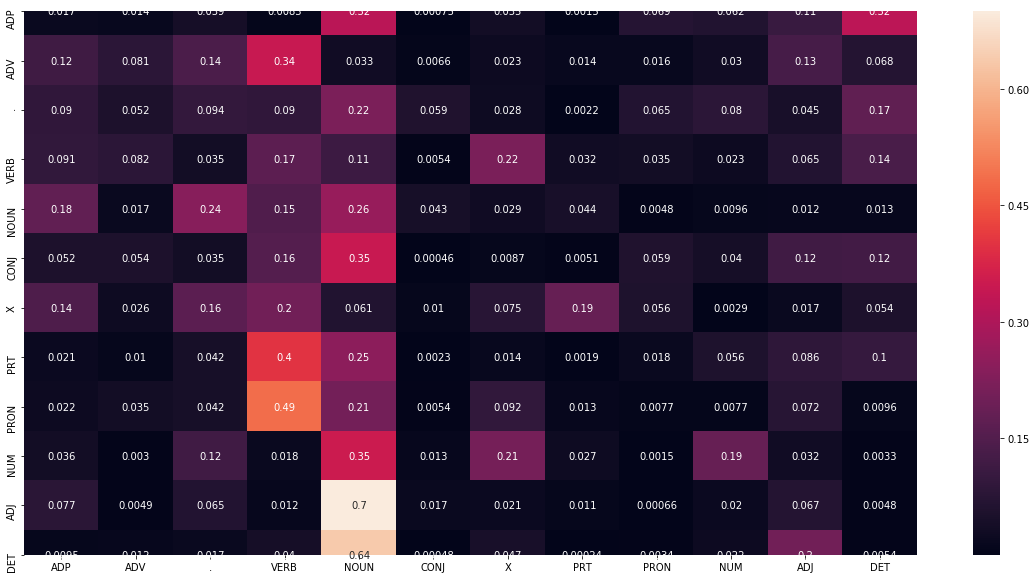

In [13]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(20, 10))
sns.heatmap(tags_df, annot = True)
plt.show()

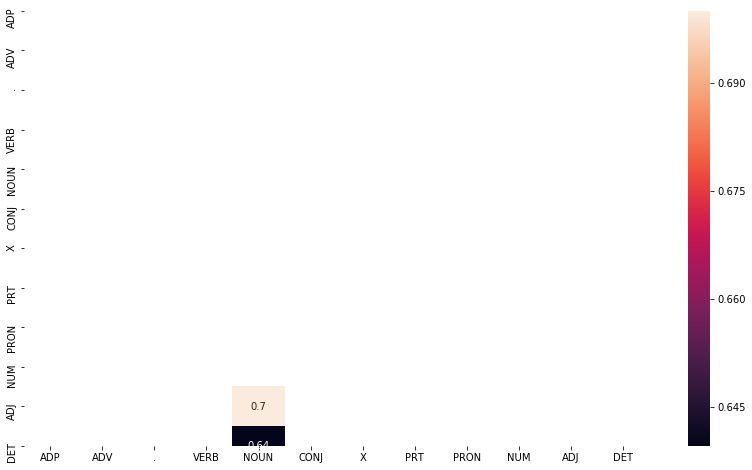

In [14]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5

tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(14, 8))
sns.heatmap(tags_frequent, annot = True)
plt.show()

### Build the vanilla Viterbi based POS tagger

In [15]:
# Viterbi Heuristic
def Vanilla_Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [17]:
random.seed(1234)

# list of tagged words
test_run_base = [tup for sent in validation_set for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in validation_set for tup in sent]


In [18]:
import time
# tagging the test sentences
start = time.time()
tagged_seq = Vanilla_Viterbi(test_tagged_words)
end = time.time()
difference = end-start


In [19]:
difference

1133.6423604488373

In [20]:
#accuracy of the vanilla viterbi algorithm
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j]
vanilla_viterbi_accuracy = len(check)/len(tagged_seq)
print("Accuracy of the Vanilla Viterbi Algorithm is: ", vanilla_viterbi_accuracy)

Accuracy of the Vanilla Viterbi Algorithm is:  0.9170875420875421


In [21]:
#Incorrect tagged cases
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
print(len(incorrect_tagged_cases))
incorrect_tagged_cases

394


[[('will', 'VERB'), (('climb', 'ADP'), ('climb', 'VERB'))],
 [('from', 'ADP'), (('566.54', 'ADP'), ('566.54', 'NUM'))],
 [('from', 'ADP'), (('28.53', 'ADP'), ('28.53', 'NUM'))],
 [('A', 'DET'), (('Different', 'ADP'), ('Different', 'NOUN'))],
 [('a', 'DET'), (('spin-off', 'ADP'), ('spin-off', 'NOUN'))],
 [('reruns', 'NOUN'), (('*T*-151', 'ADP'), ('*T*-151', 'X'))],
 [('taken', 'VERB'), (('off', 'PRT'), ('off', 'ADV'))],
 [('of', 'ADP'), (('home-market', 'ADP'), ('home-market', 'ADJ'))],
 [('home-market', 'ADJ'), (('stock-index', 'ADJ'), ('stock-index', 'NOUN'))],
 [('and', 'CONJ'), (('Osaka', 'ADP'), ('Osaka', 'NOUN'))],
 [('the', 'DET'), (('cushion', 'ADP'), ('cushion', 'NOUN'))],
 [('traditional', 'ADJ'), (('open-end', 'ADP'), ('open-end', 'ADJ'))],
 [('these', 'DET'), (('one-country', 'ADP'), ('one-country', 'ADJ'))],
 [('*-1', 'X'), (('issuing', 'ADP'), ('issuing', 'VERB'))],
 [('shares', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('the', 'DET'), (('roof', 'ADP'), ('roof', 'NOU

In [23]:
# Unknown words 
test_vocabulary_set = set([t for t in test_tagged_words])
unknown_words = list(test_vocabulary_set - training_vocabulary_set)
print("Unknown words :", len(unknown_words))

Unknown words : 279


### Solve the problem of unknown words

#### Method 1

If a word is not present in the training set the viterbi algorithm assigns the state probability as 0 because the emission probability is 0.
In this case we can set the state probability as the emission probability
Lets see what happens when we do that

In [24]:
# Modified Viterbi Heuristic
def Vanilla_Viterbi_for_Unknown_Words(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            
            # modification to the original vanilla viterbi algorithm 
            # to consider unknown words
            if word not in training_vocabulary_set:
                state_probability = transition_p
            else:
                state_probability = emission_p * transition_p
                
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [25]:
# tagging the test sentences
unknown_word_tagged_seq = Vanilla_Viterbi_for_Unknown_Words(test_tagged_words)

# accuracy
unknown_word_check = [i for i, j in zip(unknown_word_tagged_seq, test_run_base) if i == j]
optimized_viterbi_accuracy = len(unknown_word_check)/len(unknown_word_tagged_seq)
print("The accuracy of the Vanilla Viterbi Algorithm after modification: ", optimized_viterbi_accuracy)

The accuracy of the Vanilla Viterbi Algorithm after modification:  0.9438131313131313


#### Method 2


In [26]:
# A trigram tagger backed off by a rule based tagger.

def trigram_tagger(word, train_set = train_set):
    
    patterns = [
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'), # Any word ending with 'ing' or 'ed' is a verb
    (r'.*ly$', 'ADV'),
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'),
    (r'.*able$', 'ADJ'), 
    (r'.*ful$', 'ADJ'),
    (r'.*ous$', 'ADJ'),
    (r'^[aA-zZ].*[0-9]+','NOUN'),     # Alpha Numeric
    (r'.*ness$', 'NOUN'),
    (r'.*\'s$', 'NOUN'),              # possessive nouns - words ending with 's
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'.*ers$', 'NOUN'),              # eg.- kinderganteners, autobioghapgers
    (r'.*ment$', 'NOUN'),
    (r'.*town$', 'NOUN'),
    (r'^(0|([*|-|$].*))','X'), # Any special character combination
    (r'.*ould$', 'X'),
    (r'(The|the|A|a|An|an|That|that|This|this|Those|those|These|these)$', 'DET'), # That/this/these/those belong to the category of Demonstrative determiners
    (r'[0-9].?[,\/]?[0-9]*','NUM'), # Numbers 
    (r'.*', 'NOUN')
    ]

    # trigram backed up by bigram which is further backed up by a regex tagger
    regex_based_tagger = nltk.RegexpTagger(patterns)
    bigram_tagger = nltk.BigramTagger(train_set, backoff = regex_based_tagger)
    trigram_regex_tagger = nltk.TrigramTagger(train_set, backoff = bigram_tagger)
    
    #trigram_regex_tagger = nltk.TrigramTagger(train_set, backoff = regex_based_tagger)
    return trigram_regex_tagger.tag_sents([[(word)]])

In [27]:
def viterbi_backedup_by_trigram_tagger(words, train_bag = train_tagged_words):
    state = []
    tag_set = list(set([pair[1] for pair in train_bag]))
    
    # use the trigram tagger backed up by the rule based tagger
    # for unknown words.
    for key, word in enumerate(words):
        if word not in training_vocabulary_set:
            unknown_word_tag = trigram_tagger(word)
            for sent in unknown_word_tag:
                for tup in sent:
                    state.append(tup[1])
        else:            
            p = [] 
            for tag in tag_set:
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
                state_probability = emission_p * transition_p    
                p.append(state_probability)
            
            pmax = max(p)
            # getting state for which probability is maximum
            state_max = tag_set[p.index(pmax)] 
            state.append(state_max)
    return list(zip(words, state))

In [28]:
# tagging the test sentences
viterbi_trigram_tagged_seq = viterbi_backedup_by_trigram_tagger(test_tagged_words)

# accuracy
viterbi_trigram_word_check = [i for i, j in zip(viterbi_trigram_tagged_seq, test_run_base) if i == j]
viterbi_trigram_accuracy = len(viterbi_trigram_word_check)/len(viterbi_trigram_tagged_seq)
print("The accuracy of the viterbi_backedup_by_trigram_tagger is -", viterbi_trigram_accuracy)

The accuracy of the viterbi_backedup_by_trigram_tagger is - 0.9627525252525253


### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [29]:
# Tagging accuracy on the validation set
acccuracy_data = [['Vanilla Viterbi', vanilla_viterbi_accuracy*100], 
                  ['Optimized Vanilla Viterbi', optimized_viterbi_accuracy*100], 
                  ['Viterbi + Trigram_tagger', viterbi_trigram_accuracy*100]]

acccuracy_data_df = pd.DataFrame(acccuracy_data, columns = ['Tagging_Algorithm', 'Tagging_Accuracy'])
acccuracy_data_df.set_index('Tagging_Algorithm', drop = True, inplace = True)
acccuracy_data_df

,Tagging_Accuracy
Tagging_Algorithm,
Vanilla Viterbi,91.708754
Optimized Vanilla Viterbi,94.381313
Viterbi + Trigram_tagger,96.275253


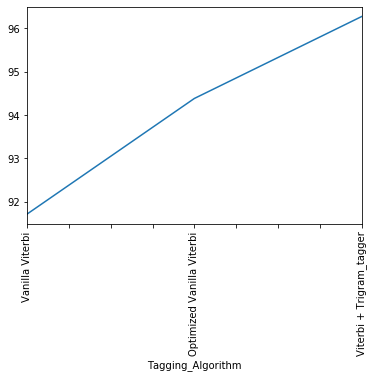

In [30]:
acccuracy_data_df.plot.line(rot = 90, legend = False)

In [31]:
# lets check the tagging accuracies of the algorithm on the sample test sentences provided -
sample_test_sentences = ["Android is a mobile operating system developed by Google.",
"Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.",
"Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.",
"Twitter is an online news and social networking service on which users post and interact with messages known as tweets.",
"Before entering politics, Donald Trump was a domineering businessman and a television personality.",
"The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.",
"This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.",
"Show me the cheapest round trips from Dallas to Atlanta",
"I would like to see flights from Denver to Philadelphia.",
"Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.",
"NASA invited social media users to experience the launch of ICESAT-2 Satellite."]

In [36]:
sample_test_tokenized_sents = [word_tokenize(sent) for sent in sample_test_sentences]
sample_test_corpus_pos_tags = nltk.pos_tag_sents(sample_test_tokenized_sents, tagset = 'universal')
sample_test_corpus_pos_tags

[[('Android', 'NOUN'),
  ('is', 'VERB'),
  ('a', 'DET'),
  ('mobile', 'ADJ'),
  ('operating', 'NOUN'),
  ('system', 'NOUN'),
  ('developed', 'VERB'),
  ('by', 'ADP'),
  ('Google', 'NOUN'),
  ('.', '.')],
 [('Android', 'NOUN'),
  ('has', 'VERB'),
  ('been', 'VERB'),
  ('the', 'DET'),
  ('best-selling', 'ADJ'),
  ('OS', 'NOUN'),
  ('worldwide', 'NOUN'),
  ('on', 'ADP'),
  ('smartphones', 'NOUN'),
  ('since', 'ADP'),
  ('2011', 'NUM'),
  ('and', 'CONJ'),
  ('on', 'ADP'),
  ('tablets', 'NOUN'),
  ('since', 'ADP'),
  ('2013', 'NUM'),
  ('.', '.')],
 [('Google', 'NOUN'),
  ('and', 'CONJ'),
  ('Twitter', 'NOUN'),
  ('made', 'VERB'),
  ('a', 'DET'),
  ('deal', 'NOUN'),
  ('in', 'ADP'),
  ('2015', 'NUM'),
  ('that', 'DET'),
  ('gave', 'VERB'),
  ('Google', 'NOUN'),
  ('access', 'NOUN'),
  ('to', 'PRT'),
  ('Twitter', 'NOUN'),
  ("'s", 'PRT'),
  ('firehose', 'NOUN'),
  ('.', '.')],
 [('Twitter', 'NOUN'),
  ('is', 'VERB'),
  ('an', 'DET'),
  ('online', 'ADJ'),
  ('news', 'NOUN'),
  ('and', 'CONJ'

In [37]:
# list of untagged words from the sample test data provided
sample_test_tagged_words = [tup[0] for sent in sample_test_corpus_pos_tags for tup in sent]

# list of tagged words
sample_test_test_run_base = [tup for sent in sample_test_corpus_pos_tags for tup in sent]

sample_test_tagged_words

['Android',
 'is',
 'a',
 'mobile',
 'operating',
 'system',
 'developed',
 'by',
 'Google',
 '.',
 'Android',
 'has',
 'been',
 'the',
 'best-selling',
 'OS',
 'worldwide',
 'on',
 'smartphones',
 'since',
 '2011',
 'and',
 'on',
 'tablets',
 'since',
 '2013',
 '.',
 'Google',
 'and',
 'Twitter',
 'made',
 'a',
 'deal',
 'in',
 '2015',
 'that',
 'gave',
 'Google',
 'access',
 'to',
 'Twitter',
 "'s",
 'firehose',
 '.',
 'Twitter',
 'is',
 'an',
 'online',
 'news',
 'and',
 'social',
 'networking',
 'service',
 'on',
 'which',
 'users',
 'post',
 'and',
 'interact',
 'with',
 'messages',
 'known',
 'as',
 'tweets',
 '.',
 'Before',
 'entering',
 'politics',
 ',',
 'Donald',
 'Trump',
 'was',
 'a',
 'domineering',
 'businessman',
 'and',
 'a',
 'television',
 'personality',
 '.',
 'The',
 '2018',
 'FIFA',
 'World',
 'Cup',
 'is',
 'the',
 '21st',
 'FIFA',
 'World',
 'Cup',
 ',',
 'an',
 'international',
 'football',
 'tournament',
 'contested',
 'once',
 'every',
 'four',
 'years',
 '.'

In [38]:
# Testing the accuracy of Vanilla Viterbi on sample test data - 
# tagging the test sentences
sample_test_tagged_seq = Vanilla_Viterbi(sample_test_tagged_words)

# Let's check the accuracy of the vanilla viterbi algorithm
sample_test_check = [i for i, j in zip(sample_test_tagged_seq, sample_test_test_run_base) if i == j]
vanilla_viterbi_accuracy_on_sample_test_data = len(sample_test_check)/len(sample_test_tagged_seq)
print("The accuracy of the Vanilla Viterbi Algorithm on the sample test data is -", vanilla_viterbi_accuracy_on_sample_test_data)

The accuracy of the Vanilla Viterbi Algorithm on the sample test data is - 0.7569060773480663


In [39]:
# Testing the accuracy of Modified Vanilla Viterbi which is Method 1 on sample test data -
# tagging the test sentences
sample_test_unknown_word_tagged_seq = Vanilla_Viterbi_for_Unknown_Words(sample_test_tagged_words)

# accuracy
sample_test_unknown_word_check = [i for i, j in zip(sample_test_unknown_word_tagged_seq, sample_test_test_run_base) if i == j]
sample_test_optimized_viterbi_accuracy = len(sample_test_unknown_word_check)/len(sample_test_unknown_word_tagged_seq)
print("The accuracy of the Vanilla_Viterbi_for_Unknown_Words on the sample test data is -", sample_test_optimized_viterbi_accuracy)

The accuracy of the Vanilla_Viterbi_for_Unknown_Words on the sample test data is - 0.861878453038674


In [40]:
# Testing the accuracy of Vanilla Viterbi backed by the Trigram tagger which is further backed by the 
# bigram tagger which is further backed by the rule based tagger which is Method 2 on sample test data -
# tagging the test sentences
sample_test_viterbi_trigram_tagged_seq = viterbi_backedup_by_trigram_tagger(sample_test_tagged_words)

# accuracy
sample_test_viterbi_trigram_check = [i for i, j in zip(sample_test_viterbi_trigram_tagged_seq, sample_test_test_run_base) if i == j]
sample_test_viterbi_trigram_accuracy = len(sample_test_viterbi_trigram_check)/len(sample_test_viterbi_trigram_tagged_seq)
print("The accuracy of the viterbi_backedup_by_trigram_tagger on the sample test data is: ", sample_test_viterbi_trigram_accuracy)

The accuracy of the viterbi_backedup_by_trigram_tagger on the sample test data is:  0.9281767955801105


In [41]:
# Tagging accuracies on the sample test data
acccuracy_on_sample_test_data = [['Vanilla Viterbi', vanilla_viterbi_accuracy_on_sample_test_data*100], 
                  ['Optimized Vanilla Viterbi', sample_test_optimized_viterbi_accuracy*100], 
                  ['Viterbi + Trigram_tagger', sample_test_viterbi_trigram_accuracy*100]]

sample_test_data_acccuracy_df = pd.DataFrame(acccuracy_on_sample_test_data, columns = ['Tagging_Algorithm', 'Tagging_Accuracy'])
sample_test_data_acccuracy_df.set_index('Tagging_Algorithm', drop = True, inplace = True)
sample_test_data_acccuracy_df

,Tagging_Accuracy
Tagging_Algorithm,
Vanilla Viterbi,75.690608
Optimized Vanilla Viterbi,86.187845
Viterbi + Trigram_tagger,92.817680


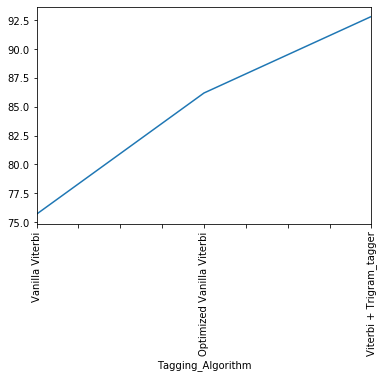

In [42]:
sample_test_data_acccuracy_df.plot.line(rot = 90, legend = False)

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [43]:
# test sentences

test_sentence_1 = "Android is a mobile operating system developed by Google."
test_sentence_2 = "Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013."
test_sentence_3 = "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose."
test_sentence_4 = "Twitter is an online news and social networking service on which users post and interact with messages known as tweets."
test_sentence_5 = "Before entering politics, Donald Trump was a domineering businessman and a television personality."
test_sentence_6 = "The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years."
test_sentence_7 = "This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe."
test_sentence_8 = "Show me the cheapest round trips from Dallas to Atlanta"
test_sentence_9 = "I would like to see flights from Denver to Philadelphia."
test_sentence_10 = "Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco."
test_sentence_11 = "NASA invited social media users to experience the launch of ICESAT-2 Satellite."

In [44]:
# Case 1
# test_sentence_1 = Android is a mobile operating system developed by Google.

words_test_sentence_1 = nltk.word_tokenize(test_sentence_1)

# pos tags with Vanilla_Viterbi
pos_tagged_sequence_with_vanilla_viterbi = Vanilla_Viterbi(words_test_sentence_1)
print("Tagging sequence with Vanilla_Viterbi -\n\n", pos_tagged_sequence_with_vanilla_viterbi)

# pos tags with viterbi_backedup_by_trigram_tagger
pos_tagged_sequence_with_viterbi_trigram = viterbi_backedup_by_trigram_tagger(words_test_sentence_1)
print("Tagging sequence with viterbi_backedup_by_trigram_tagger -\n\n", pos_tagged_sequence_with_viterbi_trigram)

Tagging sequence with Vanilla_Viterbi -

 [('Android', 'ADP'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'ADP'), ('.', '.')]
Tagging sequence with viterbi_backedup_by_trigram_tagger -

 [('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.')]


In [45]:
# Case 2
# test_sentence_4 = Twitter is an online news and social networking service on which users post and 
#                   interact with messages known as tweets.

words_test_sentence_4 = nltk.word_tokenize(test_sentence_4)

# pos tags with Vanilla_Viterbi
pos_tagged_sequence_with_vanilla_viterbi_4 = Vanilla_Viterbi(words_test_sentence_4)
print("Tagging sequence with Vanilla_Viterbi -\n\n", pos_tagged_sequence_with_vanilla_viterbi_4)

# pos tags with viterbi_backedup_by_trigram_tagger
pos_tagged_sequence_with_viterbi_trigram_4 = viterbi_backedup_by_trigram_tagger(words_test_sentence_4)
print("Tagging sequence with viterbi_backedup_by_trigram_tagger -\n\n", pos_tagged_sequence_with_viterbi_trigram_4)

Tagging sequence with Vanilla_Viterbi -

 [('Twitter', 'ADP'), ('is', 'VERB'), ('an', 'DET'), ('online', 'ADP'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('users', 'NOUN'), ('post', 'NOUN'), ('and', 'CONJ'), ('interact', 'ADP'), ('with', 'ADP'), ('messages', 'ADP'), ('known', 'ADJ'), ('as', 'ADP'), ('tweets', 'ADP'), ('.', '.')]
Tagging sequence with viterbi_backedup_by_trigram_tagger -

 [('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('users', 'NOUN'), ('post', 'NOUN'), ('and', 'CONJ'), ('interact', 'NOUN'), ('with', 'ADP'), ('messages', 'VERB'), ('known', 'VERB'), ('as', 'ADP'), ('tweets', 'NOUN'), ('.', '.')]


In [46]:
# Case 3
# test_sentence_7 = This is the first World Cup to be held in Eastern Europe and the 11th time 
#                   that it has been held in Europe.

words_test_sentence_7 = nltk.word_tokenize(test_sentence_7)

# pos tags with Vanilla_Viterbi
pos_tagged_sequence_with_vanilla_viterbi_7 = Vanilla_Viterbi(words_test_sentence_7)
print("Tagging sequence with Vanilla_Viterbi -\n\n", pos_tagged_sequence_with_vanilla_viterbi_7)

# pos tags with viterbi_backedup_by_trigram_tagger
pos_tagged_sequence_with_viterbi_trigram_7 = viterbi_backedup_by_trigram_tagger(words_test_sentence_7)
print("Tagging sequence with viterbi_backedup_by_trigram_tagger -\n\n", pos_tagged_sequence_with_viterbi_trigram_7)

Tagging sequence with Vanilla_Viterbi -

 [('This', 'DET'), ('is', 'VERB'), ('the', 'DET'), ('first', 'ADJ'), ('World', 'NOUN'), ('Cup', 'ADP'), ('to', 'PRT'), ('be', 'VERB'), ('held', 'VERB'), ('in', 'ADP'), ('Eastern', 'NOUN'), ('Europe', 'NOUN'), ('and', 'CONJ'), ('the', 'DET'), ('11th', 'ADJ'), ('time', 'NOUN'), ('that', 'ADP'), ('it', 'PRON'), ('has', 'VERB'), ('been', 'VERB'), ('held', 'VERB'), ('in', 'ADP'), ('Europe', 'NOUN'), ('.', '.')]
Tagging sequence with viterbi_backedup_by_trigram_tagger -

 [('This', 'DET'), ('is', 'VERB'), ('the', 'DET'), ('first', 'ADJ'), ('World', 'NOUN'), ('Cup', 'NOUN'), ('to', 'PRT'), ('be', 'VERB'), ('held', 'VERB'), ('in', 'ADP'), ('Eastern', 'NOUN'), ('Europe', 'NOUN'), ('and', 'CONJ'), ('the', 'DET'), ('11th', 'ADJ'), ('time', 'NOUN'), ('that', 'ADP'), ('it', 'PRON'), ('has', 'VERB'), ('been', 'VERB'), ('held', 'VERB'), ('in', 'ADP'), ('Europe', 'NOUN'), ('.', '.')]


In [47]:
# Case 4
# test_sentence_11 = NASA invited social media users to experience the launch of ICESAT-2 Satellite.

words_test_sentence_11 = nltk.word_tokenize(test_sentence_11)

# pos tags with Vanilla_Viterbi
pos_tagged_sequence_with_vanilla_viterbi_11 = Vanilla_Viterbi(words_test_sentence_11)
print("Tagging sequence with Vanilla_Viterbi -\n\n", pos_tagged_sequence_with_vanilla_viterbi_11)

# pos tags with viterbi_backedup_by_trigram_tagger
pos_tagged_sequence_with_viterbi_trigram_11 = viterbi_backedup_by_trigram_tagger(words_test_sentence_11)
print("Tagging sequence with viterbi_backedup_by_trigram_tagger -\n\n", pos_tagged_sequence_with_viterbi_trigram_11)

Tagging sequence with Vanilla_Viterbi -

 [('NASA', 'ADP'), ('invited', 'ADP'), ('social', 'ADJ'), ('media', 'NOUN'), ('users', 'NOUN'), ('to', 'PRT'), ('experience', 'NOUN'), ('the', 'DET'), ('launch', 'NOUN'), ('of', 'ADP'), ('ICESAT-2', 'ADP'), ('Satellite', 'ADP'), ('.', '.')]
Tagging sequence with viterbi_backedup_by_trigram_tagger -

 [('NASA', 'NOUN'), ('invited', 'VERB'), ('social', 'ADJ'), ('media', 'NOUN'), ('users', 'NOUN'), ('to', 'PRT'), ('experience', 'NOUN'), ('the', 'DET'), ('launch', 'NOUN'), ('of', 'ADP'), ('ICESAT-2', 'NOUN'), ('Satellite', 'NOUN'), ('.', '.')]


## As you can see that were many words which were tagged incorrectly by the vanilla viterby and the modified viterbi algorithm corrected them
    * For example in Case 2 Twitter was tagger as ADP but then it was corrected to NOUN
    * And, in Case 4 NASA was also tagged as ADP and then later corrected to NOUN